# Notebook to Infer PRotein Structure Using SIREN Models for Neural Implicit Representations of Proteins
A lot of the code in this notebook is based on the Colab notebook offered by the original authors of the SIREN paper, Vincent Sitzmann*, Julien N. P. Martel*, Alexander Bergman, David B. Lindell, and Gordon Wetzstein. This notebook can be found here: https://colab.research.google.com/github/vsitzmann/siren/blob/master/explore_siren.ipynb

In [1]:
# Library installations

'''
!pip install -U scikit-image
!pip install gemmi
'''

'\n!pip install -U scikit-image\n!pip install gemmi\n'

In [23]:
# Imports

import torch # https://pytorch.org/
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

import numpy as np
import skimage
import matplotlib # This is imported solely to see version
import matplotlib.pyplot as plt

import scipy.ndimage

import time
import gc

import gemmi # https://gemmi.readthedocs.io/en/latest/

In [24]:
print('PyTorch Version:', torch.__version__)
print('NumPy Version:', np.__version__)
print('scikit-image Version:', skimage.__version__)
print('Matplotlib Version:', matplotlib.__version__)
print('SciPy Version:', scipy.ndimage.__version__)
print('Gemmi Version:', gemmi.__version__)

PyTorch Version: 1.4.0
NumPy Version: 1.19.2
scikit-image Version: 0.18.1
Matplotlib Version: 3.3.2
SciPy Version: 2.0
Gemmi Version: 0.4.2


In [3]:
# Helper Functions

def get_mgrid(sidelen, dim=3):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [4]:
# SIREN Model Definition

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

## Use the cell below to specify the filename of the SIREN PyTorch model to be imported

In [10]:
model_filename = 'siren_model.pt'

In [12]:
# Loading model

siren_model = torch.load(model_filename)
siren_model.eval()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Use the cell below to select which protein to import and use for comparison
The two cells below are where more protein structures can be added


- t20s: T20S proteasome (https://www.ebi.ac.uk/pdbe/emdb/empiar/entry/10025/)
- trpv1: TRPV1 in complex with DkTx and RTX, determined in lipid nanodisc (https://www.ebi.ac.uk/pdbe/emdb/empiar/entry/10059/)
- rnlrp1: rNLRP1-rDPP9 complex (https://www.ebi.ac.uk/pdbe/entry/emdb/EMD-30458)

In [5]:
protein = 't20s' # One of 't20s', 'trpv1', 'rnlrp1'

In [6]:
if protein == 't20s':
    downsample_factor = 0.5 # Structure is downsampled to 1/2 of the size
    cropping = 50 # 50 pixels cropped from each side of each axis

    # Getting test T20S map
    if not os.path.exists('emd_6287.map.gz'):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-6287/map/emd_6287.map.gz
    if not os.path.exists('emd_6287.map'):
        !gunzip 'emd_6287.map.gz'
    map_path = 'emd_6287.map'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map(map_path)
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)

    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[cropping:-cropping, cropping:-cropping, cropping:-cropping, :]

    structure = scipy.ndimage.zoom(structure, (downsample_factor, downsample_factor, downsample_factor, 1))
    
    px_to_A = 0.98 # T20S dataset specific
    
elif protein == 'trpv1':
    downsample_factor = 0.75 # Structure is downsampled to 3/4 of the size
    cropping = 30 # 30 pixels cropped from each side of each axis

    # Getting test TRPV1 map
    map_filename = 'emd_8117.map.gz'
    map_path = map_filename.replace('.gz', '')
    if not os.path.exists(map_filename):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-8117/map/emd_8117.map.gz
    if not os.path.exists(map_path):
        !gunzip 'emd_8117.map.gz'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map('emd_8117.map')
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)

    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[cropping:-cropping, cropping:-cropping, cropping:-cropping, :]

    structure = scipy.ndimage.zoom(structure, (downsample_factor, downsample_factor, downsample_factor, 1))
    
    px_to_A = 1.22 # TRPV1 dataset specific
    
elif protein == 'rnlrp1':
    downsample_factor = 0.5 # Structure is downsampled to 1/2 of the size
    cropping = 40 # 40 pixels cropped from each side of each axis

    # Getting test rNLRP1-rDPP9 map
    map_filename = 'emd_30458.map.gz'
    map_path = map_filename.replace('.gz', '')
    if not os.path.exists(map_filename):
        !wget ftp://ftp.ebi.ac.uk/pub/databases/emdb/structures/EMD-30458/map/emd_30458.map.gz
    if not os.path.exists(map_path):
        !gunzip 'emd_30458.map.gz'

    # https://bioinformatics.stackexchange.com/questions/13079/ccp4-file-to-a-python-3-numpy-array-or-similar-workaround
    test_map = gemmi.read_ccp4_map('emd_30458.map')
    test_map.setup()  # optional

    raw_structure = np.array(test_map.grid, copy=False)

    structure = np.expand_dims(raw_structure, axis=-1)
    structure = structure[cropping:-cropping, cropping:-cropping, cropping:-cropping, :]

    structure = scipy.ndimage.zoom(structure, (downsample_factor, downsample_factor, downsample_factor, 1))
    
    px_to_A = 1.06 # rNLRP1-rDPP9 dataset specific

else:
    assert False, "Non-valid protein specified"

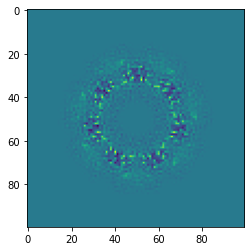

In [7]:
# Showing x-axis central slice of structure used for training

plt.imshow(structure[:, :, structure.shape[2] // 2])
plt.show()

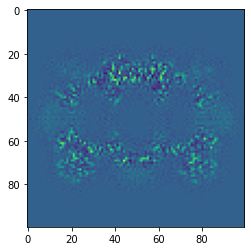

In [8]:
# Showing y-axis central slice of structure used for training

plt.imshow(structure[:, structure.shape[1] // 2, :])
plt.show()

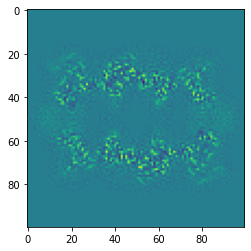

In [9]:
# Showing z-axis central slice of structure used for training

plt.imshow(structure[structure.shape[0] // 2, :, :])
plt.show()

## Shape of the inferred protein structure can be selected in the cell below
desired_shape = 256 will result with an inferred structure of shape (256, 256, 256)

In [13]:
desired_shape = structure.shape[0]

In [14]:
input_coords = get_mgrid(desired_shape, 3)
dataloader = DataLoader(input_coords, batch_size=1024, pin_memory=True, num_workers=0)

all_coords = []
all_densities = []

num_processed = 0
num_input = 0
for batch, model_input in enumerate(dataloader):
    model_input = model_input.cuda()
    
    model_output, coords = siren_model(model_input)
    all_coords.append(coords.cpu().detach().numpy().squeeze())
    # all_coords.append(model_input.cpu().detach().numpy().squeeze())
    all_densities.append(model_output.cpu().detach().numpy().squeeze())
    num_processed += len(model_output.cpu().detach().numpy().squeeze())
    num_input += len(model_input)
    
all_coords = np.concatenate(all_coords, axis=0)
all_densities = np.concatenate(all_densities, axis=0)

all_coords_transformed = np.stack(np.meshgrid(*(3 * [np.linspace(0, desired_shape - 1, desired_shape)])), axis=-1).reshape(-1, 3).astype(int)

all_coords_z = all_coords_transformed[:, 0]
all_coords_y = all_coords_transformed[:, 1]
all_coords_x = all_coords_transformed[:, 2]

final_siren_output = np.zeros((desired_shape, desired_shape, desired_shape))
final_siren_output[all_coords_y, all_coords_z, all_coords_x] = all_densities

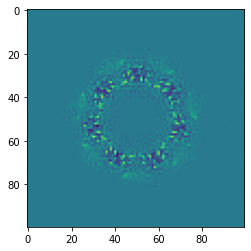

In [15]:
# Showing x-axis central slice of structure from inference

plt.imshow(final_siren_output[:, :, structure.shape[2] // 2])
plt.show()

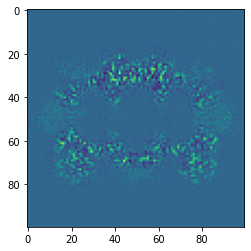

In [16]:
# Showing y-axis central slice of structure from inference

plt.imshow(final_siren_output[:, structure.shape[1] // 2, :])
plt.show()

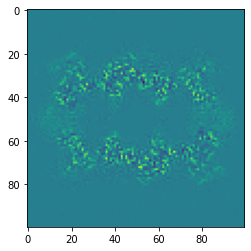

In [17]:
# Showing z-axis central slice of structure from inference

plt.imshow(final_siren_output[structure.shape[0] // 2, :, :])
plt.show()

## FSC calculation arguments can be selected in the cell below
shell_size indicates depth of shells used in FSC calculation. Smaller values will increase precision and computation time. Must be greater than 0.

In [18]:
shell_size = 2

In [20]:
# FSC Calculation
# Based on https://tttrlib.readthedocs.io/en/latest/auto_examples/imaging/plot_imaging_frc.html

original_image = structure
pred_image = final_siren_output

# Calculations
F1 = np.fft.fftn(original_image.squeeze() / np.sum(original_image), axes=(0,1,2))
F2 = np.fft.fftn(pred_image.squeeze() / np.sum(pred_image), axes=(0,1,2))

F1F2 = np.real(F1 * np.conj(F2))
F1_abs_squared = np.abs(F1)**2
F2_abs_squared = np.abs(F2)**2

nx, ny, nz = F1F2.shape
x = np.arange(-np.floor(nx / 2.0), np.ceil(nx / 2.0))
y = np.arange(-np.floor(ny / 2.0), np.ceil(ny / 2.0))
z = np.arange(-np.floor(nz / 2.0), np.ceil(nz / 2.0))

distances = []
numerators = []
F1_norms = []
F2_norms = []

for xi, yi, zi in np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3):
    distances.append(np.sqrt((xi ** 2) + (yi ** 2) + (zi ** 2)))
    xi = int(xi)
    yi = int(yi)
    zi = int(zi)
    
    numerators.append(F1F2[xi, yi, zi])
    F1_norms.append(F1_abs_squared[xi, yi, zi])
    F2_norms.append(F2_abs_squared[xi, yi, zi])
    
bins = np.arange(0, np.sqrt(((nx // 2) ** 2) + ((ny // 2) ** 2) + ((nz // 2) ** 2)), shell_size)
F1F2_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=numerators
)
F1_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F1_norms
)
F2_norm_histogram, bin_edges = np.histogram(
    distances,
    bins=bins,
    weights=F2_norms
)

FSC_vals = F1F2_histogram / np.sqrt(F1_norm_histogram * F2_norm_histogram)

/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/u/jyoo/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


Resolution: 2.2866666666666666


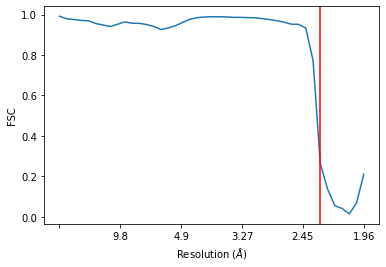

In [47]:
# FSC Plotting

def convert_freq_to_resolution(frequencies, px_to_A):
    resolutions = 1 / frequencies
    resolutions[resolutions == np.inf] = 0
    resolutions *= px_to_A
    
    return resolutions

# Setting up x-axis
frequencies = np.linspace(0, 0.5, num=len(FSC_vals))
resolutions = convert_freq_to_resolution(frequencies, px_to_A)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(frequencies, FSC_vals)
ax.set_xticklabels(np.around(convert_freq_to_resolution(ax.get_xticks(), px_to_A), 2))
negligible_threshold_check = np.where((FSC_vals < 0.5) == True)[0]
if len(negligible_threshold_check) > 0:
    resolution = resolutions[negligible_threshold_check[0]]
    ax.axvline(x=frequencies[negligible_threshold_check[0]], color='red')
    print("Resolution:", resolution)
ax.set_xlabel('Resolution (' + r'$\AA$' + ')')
ax.set_ylabel('FSC')
plt.setp(ax.get_xticklabels()[1], visible=False)
plt.show()